# CSC 620 -- HA #10

By: Mark Kim

Adapted from
[dbaghern](https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines/notebook)

This assignment extends from assignment #9.  In this assignment, we will be
doing the following:
1. Experiment with 2-fold, 10-fold, and 20-fold cross-validation.
2. Display the 10 most and least important features along with the weights of
   the three new features added in assignment #9.
3. Analyze the errors: print 10 data-points where the prediction was incorrect,
   their feature vectors, predicted label and ground truth label.
4. Write a report:
    - Compare and contrast model performance between the three CV settings
    - Analyze feature importance for each class.
    - Report on 3 trends/patterns on the errors.

Below, we import the libraries we need and read in our training data.  This data
consists of sentences from horror stories and their authors.  The purpose of this notebook is
to predict the author of a horror story sentence given its text.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('./input/train.csv')

df.dropna(axis=0)
df.set_index('id', inplace = True)

df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


## Preprocessing and Feature Engineering

The function in this next cell does a little bit of text normalization 
(removal of punctuation and capitalization), then does some feature engineering.

The feature engineering of the original author consists of the following:
1. Number of characters in the sentence/text.
2. Number of words in the sentence/text (minus stopwords).
3. Average word length of words in sentence/text (minus stopwords).
4. Number of commas used in a sentence/text.

Starting on line 26 of the code below, I have implemented the three additional
features required by the assignment:
1. Number of Adjectives.
2. Number of Nouns.
3. Number of Verbs.

In [2]:
import re
from nltk.corpus import stopwords
from nltk.tag import pos_tag

stopWords = set(stopwords.words('english'))

#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
def processing(df):
    #lowering and removing punctuation
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    #numerical feature engineering
    #total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    #get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(
        lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    #get the average word length
    df['avg_word_length'] = df['processed'].apply(
        lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) 
            if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    #get the average word length
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    # This section adds the three new features as required in the assignment instructions
    # tokenize and tag parts of speech for processing
    df['pos'] = df['processed'].apply(lambda x: x.split(' ')).apply(lambda x: pos_tag(x))
    # get the count of adjectives
    adj = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'JJ' 
        or y[1] == 'JJR' 
        or y[1] == 'JJS', x)))
    df['adj_count'] = adj.apply(lambda x: len(x))
    # get the count of nouns
    noun = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'NN' 
        or y[1] == 'NNS' 
        or y[1] == 'NNP'
        or y[1] == 'NNPS', x)))
    df['noun_count'] = noun.apply(lambda x: len(x))
    # get the count of verbs
    verb = df['pos'].apply(
        lambda x: list(filter(lambda y: y[1] == 'VB' 
        or y[1] == 'VBD' 
        or y[1] == 'VBG'
        or y[1] == 'VBN' 
        or y[1] == 'VBP'
        or y[1] == 'VBZ', x)))
    df['verb_count'] = verb.apply(lambda x: len(x))

    return(df)

df = processing(df)

df.head()

,text,author,processed,length,words,words_not_stopword,avg_word_length,commas,pos,adj_count,noun_count,verb_count
id,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,224,41,21,6.380952,4,"[(this, DT), (process, NN), (however, RB), (af...",2,12,6
id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,70,14,6,6.166667,0,"[(it, PRP), (never, RB), (once, RB), (occurred...",1,2,2
id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,195,36,19,5.947368,4,"[(in, IN), (his, PRP$), (left, JJ), (hand, NN)...",5,10,4
id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,202,34,21,6.476190,3,"[(how, WRB), (lovely, RB), (is, VBZ), (spring,...",6,10,5
id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,170,27,16,7.187500,2,"[(finding, VBG), (nothing, NN), (else, RB), (n...",1,6,6


### Further split the `test.csv` set in to train and test sets.

Here we get extract the feature columns from the dataframe (with one that has
all features and another that only has numeric features).

Then the set is split into train and test sets.

In [3]:
from sklearn.model_selection import train_test_split

features= [c for c in df.columns.values if c  not in ['id','text','author','pos']]
numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed','pos']]
target = 'author'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
X_train.head()

,processed,length,words,words_not_stopword,avg_word_length,commas,adj_count,noun_count,verb_count
id,,,,,,,,,
id19417,this panorama is indeed glorious and i should ...,91,18,6,6.666667,1,1,4,2
id09522,there was a simple natural earnestness about h...,240,44,18,6.277778,4,7,8,7
id22732,who are you pray that i duc de lomelette princ...,387,74,38,5.552632,9,3,18,10
id10351,he had gone in the carriage to the nearest tow...,118,24,11,5.363636,0,1,8,3
id24580,there is no method in their proceedings beyond...,71,13,5,7.000000,1,0,4,1


### Creating a Pipeline

First, we create functions that will return a single column from a dataframe as
a Pandas Series.  Apparently, the original author ran into problems between
trying to select a text column versus a numerical column, so a separate class
was created for each.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    


Here a pipeline is formed that will retrieve the `processed` text column from a
dataframe, then applies the `TfidfVectorizer` to the resulting Pandas Series.

I have explained the `TfidfVectorizer` in detail in a previous assignment.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

text = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

text.fit_transform(X_train)

<13117x21516 sparse matrix of type '<class 'numpy.float64'>'
	with 148061 stored elements in Compressed Sparse Row format>

A similar pipeline is applied to the numeric data from the dataframe.  In this
case the data is standardized by removing the mean and scaling to unit variance.
This score is calculated by applying the following function on each sample, $x$:
$$ z = \frac{x - \mu}{\sigma}. $$

This is done to ensure that the data is centered around $0$ and looks similar to
a standard normal distribution because many parts used in the objective function
of learning algorithms assume standard distribution.

In [6]:
from sklearn.preprocessing import StandardScaler

length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

length.fit_transform(X_train)

array([[-0.50769254],
       [ 0.88000324],
       [ 2.24907223],
       ...,
       [-0.46112557],
       [-0.14447015],
       [-0.39593181]])

The same process is followed for each of the other numeric features.

In [7]:
words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])
words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler()),
            ])
adj_count =  Pipeline([
                ('selector', NumberSelector(key='adj_count')),
                ('standard', StandardScaler())
            ])
noun_count =  Pipeline([
                ('selector', NumberSelector(key='noun_count')),
                ('standard', StandardScaler())
            ])
verb_count =  Pipeline([
                ('selector', NumberSelector(key='verb_count')),
                ('standard', StandardScaler()),
            ])

`FeatureUnion` is then used to create a concatenated results from all the
`Pipeline` objects.  This resulting estimator applies the pipelines in parallel.
The author then puts the FeatureUnion estimator into a pipeline to demonstrate a
fit/transformation on the training set.

In [8]:
from sklearn.pipeline import FeatureUnion

feats_original = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas)])

Here, I added the three new features to the `FeatureUnion` for analysis.

In [9]:
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas),
                      ('adj_count', adj_count),
                      ('noun_count', noun_count),
                      ('verb_count', verb_count)])

### Adding a Classifier

Ultimately, the author expanded the previous cell by adding a `RandomForestClassifier`
to the pipeline so that it can be trained/fit to the dataset.  Notice that the
model predicted the test set correctly $67.92\%$ of the time.  In our case, we
will be using Logistic Regression instead as shown in the cell following this
commented out cell.

In [10]:
# from sklearn.ensemble import RandomForestClassifier

# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', RandomForestClassifier(random_state = 42)),
# ])

# pipeline.fit(X_train, y_train)

# preds = pipeline.predict(X_test)
# np.mean(preds == y_test)

### 2a Using Logistic Regression instead of Random Forest

This cell implements the use of Logistic Regression over Random Forest

In [11]:
from sklearn.linear_model import LogisticRegression

pipeline_original = Pipeline([
    ('features',feats_original),
    ('classifier', LogisticRegression(max_iter=350, random_state = 42)),
])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(max_iter=350, random_state = 42)),
])

pipeline_original.fit(X_train, y_train)
pipeline.fit(X_train, y_train)

preds_original = pipeline_original.predict(X_test)
preds = pipeline.predict(X_test)
print("Original: ", np.mean(preds_original == y_test))
print("New: ", np.mean(preds == y_test))

Original:  0.7807180439492417
New:  0.780099040544723


### 2c - Classification Report

This is the classification report before cross-validation/hyperparameter tuning.
Although, it is not shown here, Logistic Regression seems to perform
significantly better than Random Forest.

In [12]:
from sklearn.metrics import classification_report

print("Old model:")
print(classification_report(y_test, preds_original))

print("New model (with 3 added features):")
print(classification_report(y_test, preds))

Old model:
              precision    recall  f1-score   support

         EAP       0.74      0.85      0.79      2587
         HPL       0.81      0.74      0.77      1852
         MWS       0.83      0.73      0.78      2023

    accuracy                           0.78      6462
   macro avg       0.79      0.77      0.78      6462
weighted avg       0.79      0.78      0.78      6462

New model (with 3 added features):
              precision    recall  f1-score   support

         EAP       0.74      0.84      0.79      2587
         HPL       0.81      0.75      0.78      1852
         MWS       0.81      0.73      0.77      2023

    accuracy                           0.78      6462
   macro avg       0.79      0.77      0.78      6462
weighted avg       0.78      0.78      0.78      6462



## Cross Validation

As was covered in class, we want to tune the parameters.  Here, the original
author explores the parameters available for tuning.

In [13]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'classifier', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__text', 'features__length', 'features__words', 'features__words_not_stopword', 'features__avg_word_length', 'features__commas', 'features__adj_count', 'features__noun_count', 'features__verb_count', 'features__text__memory', 'features__text__steps', 'features__text__verbose', 'features__text__selector', 'features__text__tfidf', 'features__text__selector__key', 'features__text__tfidf__analyzer', 'features__text__tfidf__binary', 'features__text__tfidf__decode_error', 'features__text__tfidf__dtype', 'features__text__tfidf__encoding', 'features__text__tfidf__input', 'features__text__tfidf__lowercase', 'features__text__tfidf__max_df', 'features__text__tfidf__max_features', 'features__text__tfidf__min_df', 'features__text__tfidf__ngram_range', 'features__text__tfidf__norm', 'features__text__tfidf__preprocessor', '

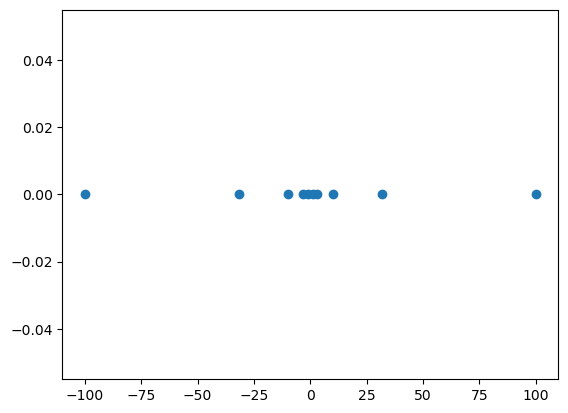

In [49]:
import matplotlib.pyplot as plt
x1 = -np.logspace(1, -1, num=10)
x2 = +np.logspace(1, -1, num=10)
x3 = np.delete(1.1-np.logspace(0, -1, num=5), 4)
x = np.append(-np.logspace(0, 2, num=5),np.logspace(0, 2, num=5))
y1 = np.zeros(10)
# plot the values
plt.plot(x, y1, 'o')
# plt.plot(x2, y1+0.1, 'o')

In [50]:
print(x)
print(x2)

[  -1.           -3.16227766  -10.          -31.6227766  -100.
    1.            3.16227766   10.           31.6227766   100.        ]
[10.          5.9948425   3.59381366  2.15443469  1.29154967  0.77426368
  0.46415888  0.27825594  0.16681005  0.1       ]


The original author chose the hyperparameters as shown in the cell below, then
does a `GridSearchCV` to tune with the list of values in the hyperparameter dictionary.

In [54]:
from sklearn.model_selection import GridSearchCV
import pickle as pkl

x = np.append(-np.logspace(0, 2, num=5),np.logspace(0, 2, num=5))

# hyperparameters_old = { 
#                     'classifier__C': x,
#                     'classifier__intercept_scaling': [0.9, 1.1]
#                   }
hyperparameters = { 
                    'classifier__class_weight': ['balanced', None],
                    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                    'classifier__C': np.logspace(0, 2, num=5),
                    'classifier__intercept_scaling': np.append(-np.logspace(0, 2, num=5),np.logspace(0, 2, num=5))
                  }
# clf_old = GridSearchCV(pipeline_original, hyperparameters_old, cv=2)
# clf = GridSearchCV(pipeline, hyperparameters, cv=2)

# clf_old.fit(X_train, y_train)
# clf.fit(X_train, y_train)

# clf_old = [GridSearchCV(pipeline_original, hyperparameters, cv=2),
#     GridSearchCV(pipeline_original, hyperparameters, cv=10),
#     GridSearchCV(pipeline_original, hyperparameters, cv=20)]
clf = [GridSearchCV(pipeline, hyperparameters, cv=2),
    GridSearchCV(pipeline, hyperparameters, cv=10),
    GridSearchCV(pipeline, hyperparameters, cv=20)]
 
# # Fit and tune the old model
# for e in clf_old:
#     e.fit(X_train, y_train)
 
# Fit and tune the new model
for e in clf:
    e.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/csc620/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniconda/base/envs/csc620/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

The best parameters are found using the `best_params_` variable.

In [63]:
# print("Old Model Best Params:")
# print(clf_old.best_params_)

print("New Model Best Params:")
print("2-fold:  ", clf[0].best_params_)
print("10-fold: ", clf[1].best_params_)
print("20-fold: ", clf[2].best_params_)

New Model Best Params:
2-fold:   {'classifier__C': 3.1622776601683795, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}
10-fold:  {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}
20-fold:  {'classifier__C': 3.1622776601683795, 'classifier__class_weight': 'balanced', 'classifier__intercept_scaling': -1.0, 'classifier__penalty': 'l2'}


Finally, we can refit the model to the best parameters using `refit`.

In [64]:
#refitting on entire training data using best settings
# clf_old.refit
for e in clf:
    e.refit

# preds_old = clf_old.predict(X_test)
# probs_old = clf_old.predict_proba(X_test)
preds = []
probs = []
for i in range(3):
    preds.append(clf[i].predict(X_test))
    probs.append(clf[i].predict_proba(X_test))

# print("Old model:")
# print(np.mean(preds_old == y_test))
print("New Model:")
for e in clf:
    print(np.mean(e == y_test))

New Model:
0.0
0.0
0.0


### 2c - Classification Report

This is the classification report after cross-validation/hyperparameter tuning.

In [61]:
# print("Old model:")
# print(classification_report(y_test, preds_original))

print("New model (with 3 added features):")
for e in clf:
    print(classification_report(y_test, e))

New model (with 3 added features):


TypeError: Expected sequence or array-like, got <class 'sklearn.model_selection._search.GridSearchCV'>

# Final Predictions

Here, the final results are gathered with the probability score for each author
for each sentence.

In [ ]:
submission = pd.read_csv('./input/test.csv')

#preprocessing
submission = processing(submission)
predictions_old = clf_old.predict_proba(submission)
predictions = clf.predict_proba(submission)

preds_old = pd.DataFrame(data=predictions_old, columns = clf_old.best_estimator_.named_steps['classifier'].classes_)
preds = pd.DataFrame(data=predictions, columns = clf.best_estimator_.named_steps['classifier'].classes_)

#generating a submission file
result_old = pd.concat([submission[['id']], preds_old], axis=1)
result_old.set_index('id', inplace = True)
print("Old:")
print(result_old.head())
print()

result = pd.concat([submission[['id']], preds], axis=1)
result.set_index('id', inplace = True)
print("New:")
print(result.head())

# Discussion

Looking at the classification report, we can see that the new model performed
slightly worse than the old model.  The reason for this is unclear since I would
have thought that the addition of the new features
would have increased the precision and recall.

One item of note is that the model
performance between the old model and the new model is pretty small.  Without
some statistical analysis, we don't really know if the difference is
statistically significant.  Given this knowledge, we really cannot conclude
anything and any analysis of this data without a deeper statistical analysis
would be anecdotal at best.

Yet another dimension to all of this is the differences in performance from the
initial fit and the model with tuned hyperparameters.  It seems that the
hyperparameter tuning I chose did not make much of a difference to the final
results.  All of this requires further investigation and analysis.